In [1]:
import numpy as np
import scipy.io as sio
import os
import sys
import torch
from matplotlib import image
import matplotlib.pyplot as plt
import torch.fft as F
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
# import gurobipy
import h5py
from importlib import reload
from torch.nn.functional import relu
import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
import utils,solvers
import time

In [2]:
reload(utils); reload(solvers)
from utils import mask_naiveRand, kplot # Jan 24, removed W1,W1T,W2,W2T
from solvers import ADMM_TV ,TVA
from sigpy.mri.app import TotalVariationRecon

Want to solve $$\underbrace{\frac{1}{2}\|\mathbf{Y}-\mathbf{M}\mathcal{F}_1 \mathbf{X}\mathcal{F}_2^\top\|_F^2}_{f(\mathbf{X})} + \underbrace{\lambda\mathrm{TV}_{\textrm{I}}(\mathbf{X})}_{g\big(\mathcal{A}(\mathbf{X})\big)}$$


## find proper $\lambda$ for Sigpy TV reconstructor

In [3]:
data  = np.load('/home/huangz78/data/traindata_x.npz')
dtyp  = torch.float
xfull = torch.tensor(data['xfull'],dtype=dtyp)
fullmask = torch.tensor(data['mask'])

In [12]:
from mask_backward_new import mask_eval
from utils import apply_mask

In [11]:
reload(utils)

<module 'utils' from '/home/huangz78/mri/utils.py'>

In [13]:
batchsize = 1
xstar = xfull[0:batchsize,:,:]

corefreq = 24
yfull = torch.fft.fftshift(F.fftn(xstar,dim=(1,2),norm='ortho')) # y is ROLLED!
lowfreqmask,_,_ = mask_naiveRand(xstar.shape[1],fix=corefreq,other=0,roll=True)

z = apply_mask(lowfreqmask,yfull,mode='c')
print(z[0,:])

tensor([[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]])


In [ ]:
NN = 10
Lambda_grid = 10**(np.linspace(-7,-3,NN))
err = np.zeros((NN))

y_sigpy = np.reshape(np.fft.fftshift(z.numpy()),(-1,imgHeg,imgWid)) 
mps = np.ones((1,imgHeg,imgWid))
for ind in range(NN):
    x_sigpy = np.fft.ifftshift(np.abs(TotalVariationRecon(y_sigpy, mps, Lambda_grid[ind],show_pbar=False).run()))
    err[ind] = np.linalg.norm(x_sigpy - xstar,'fro') / np.linalg.norm(xstar,'fro')


### a typical cell to test one reconstruction result of the solver

In [3]:
data = np.load('/home/huangz78/data/data_gt.npz')
imgs = data['imgdata']

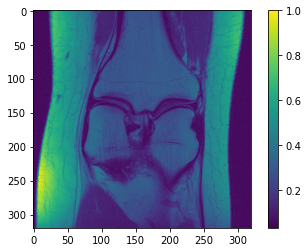

In [5]:
xstar = torch.tensor(imgs[:,:,27]).view(320,320,-1)
xstar = xstar / torch.max(torch.flatten(torch.abs(xstar)))
plt.figure()
plt.imshow(xstar)
plt.colorbar()
plt.show()

y = F.fftn(xstar,dim=(0,1),norm='ortho')

In [ ]:
reload(solvers)
from solvers import ADMM_TV , TVA

Lambda  = 1e-3; # anisotropic
rho     = 1e1
maxIter = 1000; cg_maxIter=10
imgHeg,imgWid = xstar.shape[0],xstar.shape[1]; DType = torch.double
mask_Base,_,_ = mask_naiveRand(imgHeg,fix=round(imgHeg*.05),other=round(imgHeg*.05))
z0   = torch.tensordot(torch.diag(mask_Base).to(DType),y.to(DType),dims=([1],[0]))
x_reconstruct,Error = ADMM_TV(z0,mask_Base,maxIter=maxIter,rho=rho,Lambda=Lambda,\
                               imgInput=False,xOrig=xstar,cgIter=cg_maxIter,verbose=True)

y_sigpy = np.reshape(np.fft.fftshift(z0.to(torch.cfloat).numpy()),(-1,imgHeg,imgWid)) 
mps = np.ones((1,imgHeg,imgWid))
x_sigpy = np.fft.ifftshift( np.real(TotalVariationRecon(y_sigpy, mps, Lambda,show_pbar=False,\
                                                        solver='ADMM',rho=rho,\
                                                        max_iter=maxIter,max_cg_iter=cg_maxIter).run()) )

err = torch.norm(torch.flatten(torch.tensor(x_sigpy))-torch.flatten(xstar),'fro') / torch.norm(torch.flatten(xstar),'fro')

plt.clf()
plt.imshow(x_reconstruct); plt.colorbar()
plt.show()

plt.clf()
plt.xlabel('iter', fontsize=18)
plt.ylabel('nrmse', fontsize=18)
plt.plot(Error,label='admm_tva')
plt.plot(err*np.ones(Error.size),label='sigpy')
plt.legend()
plt.show()

ADMM_A iter 250 out of 1000
ADMM_A iter 500 out of 1000
ADMM_A iter 750 out of 1000
ADMM_A iter 1000 out of 1000


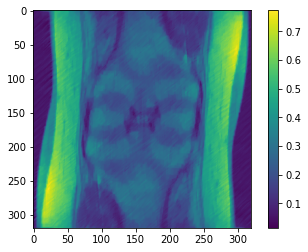

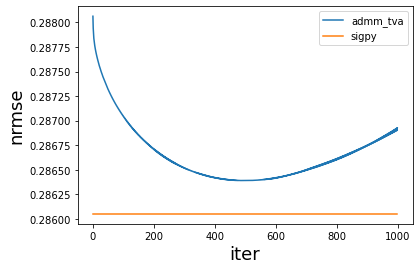

In [9]:
reload(solvers)
from solvers import ADMM_TV , TVA

Lambda  = 1e-3; # anisotropic
rho     = 1e1
maxIter = 1000; cg_maxIter=10
imgHeg,imgWid = xstar.shape[0],xstar.shape[1]; DType = torch.double
mask_Base,_,_ = mask_naiveRand(imgHeg,fix=round(imgHeg*.05),other=round(imgHeg*.05))
z0   = torch.tensordot(torch.diag(mask_Base).to(DType),y.to(DType),dims=([1],[0]))
x_reconstruct,Error = ADMM_TV(z0,mask_Base,maxIter=maxIter,rho=rho,Lambda=Lambda,\
                               imgInput=False,xOrig=xstar,cgIter=cg_maxIter,verbose=True)

y_sigpy = np.reshape(np.fft.fftshift(z0.to(torch.cfloat).numpy()),(-1,imgHeg,imgWid)) 
mps = np.ones((1,imgHeg,imgWid))
x_sigpy = np.fft.ifftshift( np.real(TotalVariationRecon(y_sigpy, mps, Lambda,show_pbar=False,\
                                                        solver='ADMM',rho=rho,\
                                                        max_iter=maxIter,max_cg_iter=cg_maxIter).run()) )

err = torch.norm(torch.flatten(torch.tensor(x_sigpy))-torch.flatten(xstar),'fro') / torch.norm(torch.flatten(xstar),'fro')

plt.clf()
plt.imshow(x_reconstruct); plt.colorbar()
plt.show()

plt.clf()
plt.xlabel('iter', fontsize=18)
plt.ylabel('nrmse', fontsize=18)
plt.plot(Error,label='admm_tva')
plt.plot(err*np.ones(Error.size),label='sigpy')
plt.legend()
plt.show()

### Check dip is there wrt to $\lambda$
- compare to sigpy solver behaviour to make sure things are sane.
    - maybe use anisotropic

In [24]:
seed = 0
imgHeg = xstar.shape[0]; imgWid=xstar.shape[1]
DType = torch.cdouble
# Lambda_ADMM_grid = 10.**np.linspace(-0.5,2.5,10)
Lambda_ADMM_grid = 10**np.linspace(-4,-3,15)
rho_grid = np.array([1e0,1e1,10**1.5,1e2])
# rho_grid = np.array([1e2])
np.random.seed(seed)
noise_mag = 0

maxIter = 500
mask_Base,_,_ = mask_naiveRand(imgHeg,fix=int(imgHeg*.3),other=0)
Y   = torch.tensordot(torch.diag(mask_Base).to(DType),y.to(DType),dims=([1],[0]))
# noise   = torch.randn_like(Y)*noise_mag
# Y       = Y+noise

# Y_sp = Y.numpy()
# Y_sp = np.reshape(Y_sp, (1, imgHeg,imgWid))
# mask_Base_sp = mask_Base.numpy()
# mps  = np.ones((1,imgHeg,imgHeg))

x_ifft = torch.real(F.ifftn(Y,dim=(0,1),norm='ortho' ))
rel_data_fidel_ifft = torch.sqrt(torch.sum( (torch.flatten(x_ifft)-torch.flatten(xstar))**2 ) ).item() / \
                                torch.sqrt(torch.sum( torch.flatten(xstar)**2 ) ).item()
data_fidel_ifft = np.ones(Lambda_ADMM_grid.size) * rel_data_fidel_ifft

data_fidel_ADMM = np.zeros((rho_grid.size,Lambda_ADMM_grid.size))

ind_rho = 0
for rho in rho_grid:
    ind_lambda = 0
#     data_fidel_sp   = np.zeros(Lambda_FDPG_grid.size)
    for Lambda_ADMM in Lambda_ADMM_grid:
        print('rho = %u, Lambda = %.3g' % (rho,Lambda_ADMM))
# Lambda_FDPG=1e1;  rho=1e2

        x_ADMM = ADMM_TV(Y,mask_Base,maxIter=maxIter,Lambda=Lambda_ADMM,rho=rho,\
         DType=torch.cdouble,imgInput=False,cgIter=1e1,cgeps=1e-8)
#         print('Rela. l2 error of x_FDPG = ', torch.sqrt(torch.sum( (torch.flatten(x_FDPG)-torch.flatten(xstar))**2 ) ).item() / \
#                                 torch.sqrt(torch.sum( torch.flatten(xstar)**2 ) ).item() )
        #         print('Rela. l2 error of x_ifft = ', torch.sqrt(torch.sum( (torch.flatten(x_ifft)-torch.flatten(xstar))**2 ) ).item() / \
#                                 torch.sqrt(torch.sum( torch.flatten(xstar)**2 ) ).item() )
        data_fidel_ADMM[ind_rho,ind_lambda] = torch.sqrt(torch.sum( (torch.flatten(x_ADMM)-torch.flatten(xstar))**2 ) ).item() / \
                                torch.sqrt(torch.sum( torch.flatten(xstar)**2 ) ).item()       
#         x_sp = np.abs(TotalVariationRecon(Y_sp,mps,Lambda_FDPG,weights=mask_Base_sp).run())
#         x_sp = np.fft.fftshift(x_sp,axes=(0,1))
#         x_sp = rescale_sp(x_sp)
# #         print('Rela. l2 error of x_sp   = ', np.sqrt(np.sum( (x_sp.flatten()-xstar.numpy().flatten())**2 ) ) / \
# #                                         np.sqrt(np.sum( xstar.numpy().flatten()**2 ) ) )
#         data_fidel_sp[ind]  = np.sqrt(np.sum( (x_sp.flatten()-xstar.numpy().flatten())**2 ) ) / \
#                                         np.sqrt(np.sum( xstar.numpy().flatten()**2 ) ) 
        ind_lambda += 1
    ind_rho += 1

rho = 1, Lambda = 0.0001
rho = 1, Lambda = 0.000118
rho = 1, Lambda = 0.000139
rho = 1, Lambda = 0.000164
rho = 1, Lambda = 0.000193
rho = 1, Lambda = 0.000228
rho = 1, Lambda = 0.000268
rho = 1, Lambda = 0.000316
rho = 1, Lambda = 0.000373
rho = 1, Lambda = 0.000439
rho = 1, Lambda = 0.000518
rho = 1, Lambda = 0.000611
rho = 1, Lambda = 0.00072
rho = 1, Lambda = 0.000848
rho = 1, Lambda = 0.001
rho = 10, Lambda = 0.0001
rho = 10, Lambda = 0.000118
rho = 10, Lambda = 0.000139
rho = 10, Lambda = 0.000164
rho = 10, Lambda = 0.000193
rho = 10, Lambda = 0.000228
rho = 10, Lambda = 0.000268
rho = 10, Lambda = 0.000316
rho = 10, Lambda = 0.000373
rho = 10, Lambda = 0.000439
rho = 10, Lambda = 0.000518
rho = 10, Lambda = 0.000611
rho = 10, Lambda = 0.00072
rho = 10, Lambda = 0.000848
rho = 10, Lambda = 0.001
rho = 31, Lambda = 0.0001
rho = 31, Lambda = 0.000118
rho = 31, Lambda = 0.000139
rho = 31, Lambda = 0.000164
rho = 31, Lambda = 0.000193
rho = 31, Lambda = 0.000228
rho = 31, Lambda = 0.

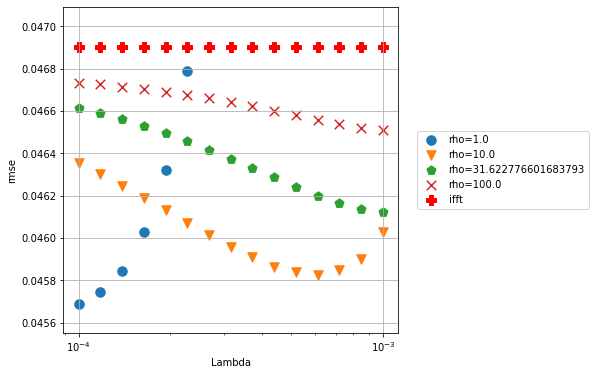

In [25]:
markers = ['o','v','p','x','*','1']
fig, ax = plt.subplots(1, 1,figsize=(6,6))
for ind_rho in range(rho_grid.size):
    ax.scatter(Lambda_ADMM_grid,data_fidel_ADMM[ind_rho,:],marker=markers[ind_rho],s=90,label='rho='+str(rho_grid[ind_rho])); # plt.show();
ax.set_xlabel('Lambda'); ax.set_ylabel('rmse'); ax.grid()
# plt.figure()
ax.scatter(Lambda_ADMM_grid,data_fidel_ifft,label='ifft',marker='P',s=90,c='r')
# #     plt.subplot(211)
# plt.scatter(Lambda_ADMM_grid,data_fidel_ADMM,label='ADMM',s=150)
ax.set_ylim([0.997*np.min(data_fidel_ADMM.flatten()) , 1.004* data_fidel_ifft[0]])
# plt.xscale('log')
# #     plt.yscale('log')
# plt.title('L=%.2f' %(L))
# plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.xscale('log')  
plt.show()

In [28]:
print(Lambda_ADMM_grid[-4],6.1e-4)

0.0006105402296585327 0.00061


In [25]:
print(np.log10(Lambda_ADMM_grid))

[-7.         -6.88888889 -6.77777778 -6.66666667 -6.55555556 -6.44444444
 -6.33333333 -6.22222222 -6.11111111 -6.        ]


### Compare performance of multiple solvers

In [ ]:
## compare to sigpy solver to make sure things are sane.
## maybe use anisotropic

reload(utils)
from utils import ADMM_TV,mask_naiveRand,TVA,FDPG

In [28]:
noise_mag = 0

maxIter = 2e2
mask_Base,_,_ = mask_naiveRand(imgHeg,fix=int(imgHeg*.2),other=0)
Y       = torch.tensordot(torch.diag(mask_Base).to(DType),y.to(DType),dims=([1],[0]))
noise   = torch.randn_like(Y) * noise_mag
Y       = Y + noise

Lambda = 14;  
# L = 1e3
x_ADMM, Error = ADMM_TV(Y,mask_Base,maxIter=maxIter,Lambda=Lambda_ADMM,rho=1e2,xOrig=xstar,\
         DType=torch.cfloat,imgInput=False,cgIter=1e3,cgverbose=False,cgeps=1e-8)
print('Rela. l2 error of x_ADMM = ', torch.sqrt(torch.sum( (torch.flatten(x_ADMM)-torch.flatten(xstar))**2 ) ).item() / \
                        torch.sqrt(torch.sum( torch.flatten(xstar)**2 ) ).item() )

# x_FDPG,Error = FDPG(Y,mask_Base,L,Lambda,maxIter=maxIter,isotropic=True,fast=True,xOrig=xstar,\
#                  imgInput=False,cgIter=20,cgverbose=True,cgeps=1e-8,wiggle=1e-8)
# print('Rela. l2 error of x_FDPG = ', torch.sqrt(torch.sum( (torch.flatten(x_FDPG)-torch.flatten(xstar))**2 ) ).item() / \
#                         torch.sqrt(torch.sum( torch.flatten(xstar)**2 ) ).item() )

x_ifft = torch.real(F.ifftn(Y,dim=(0,1),norm='ortho' ))
print('Rela. l2 error of x_ifft = ', torch.sqrt(torch.sum( (torch.flatten(x_ifft)-torch.flatten(xstar))**2 ) ).item() / \
                                torch.sqrt(torch.sum( torch.flatten(x_star)**2 ) ).item() )

# Y_sp = Y.numpy()
# Y_sp = np.reshape(Y_sp, (1, imgHeg,imgWid))
# mask_Base_sp = mask_Base.numpy()
# mps  = np.ones((1,imgHeg,imgHeg))
# x_sp = np.abs(TotalVariationRecon(Y_sp,mps,1e0,weights=mask_Base_sp).run())
# x_sp = np.fft.fftshift(x_sp,axes=(0,1))
# x_sp = rescale_sp(x_sp)
# print('Rela. l2 error of x_sp   = ', np.sqrt(np.sum( (x_sp.flatten()-x_star.numpy().flatten())**2 ) ) / \
#                                 np.sqrt(np.sum( x_star.numpy().flatten()**2 ) ) )

plt.subplot(121)
plt.imshow(x_ADMM)
plt.title('ADMM recon.')
plt.colorbar()
plt.show()
# plt.subplot(121)
# plt.imshow(x_FDPG)
# plt.title('FDPG recon.')
# plt.colorbar()
# plt.show()

plt.subplot(122)
plt.imshow(x_ifft)
plt.title('iFFT recon.')
plt.colorbar()

# plt.show()
plt.figure()
plt.plot(Error)
# plt.xscale('log')
# plt.yscale('log')
plt.title('data fidelity')
plt.show()

NameError: name 'x_star' is not defined

### parameter select: which parameter works the best for a given solver

In [ ]:
def params_select(y,alpha_grid=5e-1,beta_grid=1e1,Lambda_grid=1e-5,rho_grid=1e2,lr_grid=1e-5,\
                  maxIter=200,unroll_block=6,seed=0,mode='ADMM',initial_observation=30,target_sparsity=None):
#     breakpoint()
    torch.manual_seed(seed)
    imgHeg = y.shape[0]
    if len(y.shape)<3:
        y = y.view((y.shape[0],y.shape[1],1)) 
    xstar = torch.real(F.ifftn(y,dim=(0,1),norm='ortho'))
    params_grid  = [[alpha,beta,Lambda,rho,lr] for alpha in alpha_grid for beta in beta_grid for Lambda in Lambda_grid for rho in rho_grid for lr in lr_grid]    
    res_error    = np.full((len(params_grid)),np.inf)
    sparsity_rec = np.full((len(params_grid)),1.0)

    params_ind   = 0
    for params in params_grid:
        loss_old = np.inf
        flag_perturb = False
        ## initialising M
        M = torch.randn(imgHeg); 
        if initial_observation > 1:
            M[0:int(initial_observation/2)]       = 1e2
            M[imgHeg-int(initial_observation/2):] = 1e2
        else:
            M[0:int(initial_observation/2*imgHeg)]      = 1e2
            M[imgHeg-int(initial_observation/2*imgHeg)] = 1e2
        M.requires_grad = True
        alpha = params[0]; beta = params[1]; Lambda = params[2]; rho = params[3]; lr = params[4]
        print('iteration %.4d out of %.4d' %(params_ind+1,len(params_grid)))
        print('alpha: %.3g, beta: %.3g, Lambda: %.3g, rho: %.3g, lr = %.3g' %(alpha,beta,Lambda,rho,lr))
#         optimizer = optim.Adam([M],lr=lr)  
#         optimizer = optim.LBFGS([M],lr=lr)  
        Iter = 0
        while Iter < maxIter:
            z0   = torch.tensordot(torch.diag(torch.sigmoid(beta*M)).to(DType),y,dims=([1],[0]))
            if mode == 'ADMM':
                x,_   = ADMM_TV(z0,torch.sigmoid(beta*M),maxIter=unroll_block,Lambda=Lambda,rho=rho,\
                                wiggle=1e-8,imgInput=False,xOrig=xstar)
            elif mode == 'IFFT': # debug
                x    = torch.real(F.ifftn(z0,dim=(0,1),norm='ortho')) # should involve the mask to cater for the lower-level objective
            loss = torch.sum((x-xstar)**2)/torch.sum(xstar**2) + alpha*torch.norm(torch.sigmoid(beta*M),p=1) 
            optimizer.zero_grad()
            loss.backward()
#             if flag_perturb:
#                 breakpoint()
#                 M.grad += 1/lr * 1/2*torch.max(torch.abs(M))
            optimizer.step()
            
            MASK_tmp = mask_makebinary(M.clone().detach(),beta,threshold=0.5)
            mask_sparsity = torch.sum(MASK_tmp).item()/imgHeg
            if (target_sparsity is not None) and (mask_sparsity <= target_sparsity):
                print('Target sparsity reached, break at iter: %.d' % (Iter+1) )
                break
            if loss.item() < loss_old:
                loss_old = loss.item()
                repCount = 0
            elif loss.item() == loss_old:
                repCount += 1
                if repCount >= 3:
                    flag_perturb = True
                    if repCount >= 6:
                        print('No further decrease in loss, breaking ADMM iterations at iteration %.4d' %(Iter+1))
                        break
#             if (Iter+1) % (maxIter//5) == 0:
#                 print('iter: %.d, total loss: %.5g' % (Iter+1,loss.item()) )
#                 MASK_tmp = mask_makebinary(M.clone().detach(),beta)
#                 print('sparsity: ',torch.sum(MASK_tmp).item()/imgHeg)
#                 print('data fidel. loss   : ', (torch.sum((x-xstar)**2)/torch.sum(xstar**2)).item() )
#                 print('sparsity pen. loss : ', alpha*torch.norm(torch.sigmoid(beta*M),p=1).item() )
#                 print('\n')
            Iter += 1
        MASK_tmp = mask_makebinary(M.clone().detach(),beta,threshold=0.5)
        if mode == 'ADMM':
            z0    = torch.tensordot(torch.diag(torch.sigmoid(beta*M)).to(DType),y,dims=([1],[0]))
            x_tmp = ADMM_TV(z0,MASK_tmp,maxIter=unroll_block,Lambda=Lambda,rho=rho,\
                                wiggle=1e-8,imgInput=False)
        res_error[params_ind]    = (torch.sum((x_tmp-xstar)**2)/torch.sum(xstar**2)).item()
        sparsity_rec[params_ind] = torch.sum(MASK_tmp).item()/imgHeg
        print('sparsity: ', sparsity_rec[params_ind])
        print('data fidel. loss   : ', res_error[params_ind] )
        params_ind += 1
        print('\n\n')
    return res_error,sparsity_rec

In [ ]:
alpha_grid  = list([1e-1,1e1,1e3,1e5])
beta_grid   = list([1e1,5e1])
Lambda_grid = list([1e-6,1e-4,1e-2])
rho_grid    = list([1e2,1e3,1e4])
lr_grid     = list([1e-1,1e0])
res_error,sparsity_rec = params_select(y,alpha_grid=alpha_grid,beta_grid=beta_grid,Lambda_grid=Lambda_grid,\
                                       rho_grid=rho_grid,lr_grid=lr_grid,maxIter=200,unroll_block=5,\
                                       seed=0,mode='ADMM',initial_observation=100,target_sparsity=0.1)

## test FDPG
- FDPG solver has been tested. 
- It is found that its first argmax step cannot be correctly executed, thus leading to the failure of the entire solver. 
    -   The first step in the FDPG pipeline is the linear system
 $$\mathrm{Re}[(\mathcal{F}_1^*\mathbf{M}\mathcal{F}_1)\mathbf{X}_k] = \mathcal{A}^\top(\mathbf{w}_k) + \mathrm{Re}[\mathcal{F}_1^*\mathbf{Y}\bar{\mathcal{F}_2}],$$
  i.e.
  $$(\mathcal{F}_1^*\mathbf{M}\mathcal{F}_1)\mathbf{X}_k = \mathcal{A}^\top(\mathbf{w}_k) + \mathcal{F}_1^*\mathbf{Y}\bar{\mathcal{F}_2}$$
    - The testing procedure is identical to that of ADMM solver.
    - for fixed mask and rho, see which Lambda leeds to the lowest reconstruction error
    - $\lambda$_FDPG_grid = 10.**np.linspace(-2,1,30)  
    - $\rho$_grid = np.array([1e1,$10^{4.5}$,1e5,$10^{5.5}$])

### Warm start: compressed sensing mask selection

In [ ]:
import cvxpy as cp
x    = cp.Variable((imgHeg,imgWid))
prob = cp.Problem(cp.Minimize( (1/2)* cp.norm(x-yhat[:,:,0],'fro')**2 + .1*cp.tv(F1@x@F2.T) ))
        # prob.solve(solver=cp.MOSEK)
prob.solve(solver=cp.GUROBI)
# print("\nThe optimal value is", prob.value)
# print("A solution x is")
# print(x.value)
# print("A dual solution corresponding to the inequality constraints is")
# print(prob.constraints[0].dual_value)

In [ ]:
def cs_mask(A,b,solver=cp.GUROBI,verbose=False,cutoff=1e-8):
    x = cp.Variable(b.size)
    prob = cp.Problem(cp.Minimize(cp.norm(x,1)),
                     [A@x==b])
    # prob.solve(solver=cp.CVXOPT)
    # prob.solve(solver=cp.MOSEK)
    # prob.solve(solver=cp.GUROBI)
    prob.solve(solver=solver)
    if verbose:
        print("\nThe optimal value is", prob.value)
        print("A solution x is: ")
        print(x.value)
    xSol = x.value
    M_cs = np.ones(xSol.shape)
    M_cs[abs(xSol)<cutoff] = 0
    return M_cs

In [ ]:
def reconstruct_test(self,z,y):

    x = cp.Variable(n)
    prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x,P) + q.T @ x),
                     [G@x <=h,
                      A@x==b])
    # prob.solve(solver=cp.MOSEK)
    prob.solve(solver=cp.GUROBI)
    print("\nThe optimal value is", prob.value)
    print("A solution x is")
    print(x.value)
    print("A dual solution corresponding to the inequality constraints is")
    print(prob.constraints[0].dual_value)